In [12]:
# for i in range(168):
#     print(f"python gaussian\ process.py --fold_num 0 --dataset zhonghang --start {i} & ")

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
# from pyod.models.iforest import IForest
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:
def find_best_percent(result, granularity_all=1000):
    """
    在误差排序中找到异常占比最高的阈值
    :param result: 误差排序结果
    :param granularity_all: 颗粒度
    :return: 最好的前n%, 检出率, 颗粒度
    """
    max_percent = 0
    best_n = 1
    print("找出最大的前n%的比例 阈值调参开始:")
    for n in tqdm(range(1, 100)):
        head_n = n / granularity_all
        data_length = max(round(len(result) * head_n), 1)
        count_dist = count_entries(result.loc[:data_length - 1], 'label')
        try:
            percent = count_dist['1'] / (count_dist['0'] + count_dist['1'])
        except KeyError:
            print("can't find n%,take 1%")
            percent = 0.01
        if percent > max_percent:
            max_percent = percent
            best_n = n
    print("前%d分之%s个数的比例最高，为%s" % (granularity_all, best_n, max_percent))
    return best_n, max_percent, granularity_all

def count_entries(df, col_name):
    """
    统计预测结果两个类别各自的数据，用于计算检出误报
    :param df: 预测结果与label合并后的表
    :param col_name: 用哪种结果 例如 l2 rec_error等
    :return: 0，1各自的数量
    """
    count_dist = {'0': 0, '1': 0}
    col = df[col_name]
    for entry in col:
        if str(int(entry)) in count_dist.keys():
            count_dist[str(int(entry))] = count_dist[str(int(entry))] + 1
        else:
            count_dist[str(int(entry))] = 1
    return count_dist

def find_best_result(threshold_n, result, dataframe_std):
    """
    计算最优检出结果
    :param threshold_n: 阈值
    :param result: 误差排序结果表
    :param dataframe_std: label
    :return: 检出结果， 最优占比，最优检出，最优误报，最优f1
    """
    best_result, best_h, best_re, best_fa, best_f1, best_precision = None, 0, 0, 0, 0, 0
    best_auroc = 0
    for h in tqdm(range(50, 1000, 50)):
        train_result = charge_to_car(threshold_n, result, head_n=h)
        f1, recall, false_rate, precision, accuracy, auroc = evaluation(dataframe_std, train_result)
        if auroc >= best_auroc:
            best_f1 = f1
            best_h = h
            best_re = recall
            best_fa = false_rate
            best_result = train_result
            best_auroc = auroc
    return best_result, best_h, best_re, best_fa, best_f1, best_auroc

def charge_to_car(threshold_n, rec_result, head_n=92):
    """
    充电段映射到车
    :param threshold_n: 阈值
    :param rec_result: 误差结果排序表
    :param head_n: 前%n
    :param gran: 颗粒度
    :return: 车辆预测结果表
    """
    gran = 1000
    result = []
    for grp in rec_result.groupby('car'):
        temp = grp[1].values[:, -1].astype(float)
        idx = max(round(head_n / gran * len(temp)), 1)
        error = np.mean(temp[:idx])
        result.append([grp[0], int(error > threshold_n), error, threshold_n])
    return pd.DataFrame(result, columns=['car', 'predict', 'error', 'threshold_n'])

def evaluation(dataframe_std, dataframe):
    """
    计算f1 检出 误报 查准 准确等率
    :param dataframe_std:
    :param dataframe:
    :return:
    """
    
    # calculate auroc
#     print(dataframe) # error car
    _label = []
    for each_car in dataframe['car']:
        if int(each_car) in ind_car_num_list:
            _label.append(0)
        if int(each_car) in ood_car_num_list:
            _label.append(1)
    
    fpr, tpr, thresholds = metrics.roc_curve(_label, list(dataframe['error']), pos_label=1)
    auroc = auc(fpr, tpr)
    
    
    data = pd.merge(dataframe_std, dataframe, on='car')
    cm = confusion_matrix(data['label'].astype(int), data['predict'].astype(int))
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    false_rate = fp / (tn + fp) if tn + fp != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    return f1, recall, false_rate, precision, accuracy, auroc

In [44]:
dataset_name = 'brand1'
ind_car_num_list = [129, 158, 152, 79, 95
        , 114, 34, 177, 99, 138, 163, 54, 45, 115, 66, 87, 47, 57, 31, 195, 36, 102,
                        72, 173, 94, 51, 92, 61, 153, 125, 103, 3, 50, 10, 7, 146, 166, 48, 75, 86, 15, 175, 64, 2, 110, 13,
                        23, 93, 116, 62, 8, 41, 22, 6, 24, 101, 46, 187, 198, 142, 131, 18, 160, 56, 29, 141, 148, 168, 71,
                        53, 104, 120, 154, 20, 17, 111, 133, 63, 35, 83, 5, 88, 159, 145, 176, 127, 77, 118, 52, 81, 121,
                        59, 38, 80, 109, 179, 28, 123, 44, 180, 149, 135, 164, 74, 40, 14, 65, 69, 42, 193, 12, 60, 73, 126,
                        161, 188, 32, 30, 170, 128, 167, 9, 155, 156, 43, 100, 33, 90, 139, 1, 112, 25, 4, 16, 189, 147,
                        124, 178, 55, 85, 122, 96, 162, 132, 89, 19, 27, 84, 39, 151, 67, 26, 172, 76, 37, 143, 58, 165, 97,
                        134, 82, 113, 137, 144, 70, 11, 117, 106]  # 169
ood_car_num_list = [91, 192, 169, 130, 140
    , 171, 190, 186, 105, 49, 181, 157, 183, 185, 194, 98, 191, 136, 119, 196, 107, 68, 108, 78, 182, 150, 174, 21, 184, 197]
dataframe_std1 = pd.read_csv(os.path.join('../data/battery_brand1/label', "train_label.csv"), dtype=object)
dataframe_std2 = pd.read_csv(os.path.join('../data/battery_brand1/label', "test_label.csv"), dtype=object)
dataframe_std = pd.concat([dataframe_std1, dataframe_std2], axis=0,ignore_index=True)


# dataset_name = 'brand2'
# ind_car_num_list = [214, 231, 233, 234, 218, 201, 211, 248, 222, 203, 223, 246, 229, 249, 227, 207, 232, 250, 208, 245,
#                         213, 228, 220, 244, 217, 238, 221, 224, 226, 216, 202, 242, 235]  # 33
# ood_car_num_list = [205, 247, 241, 204, 206, 210, 243, 240, 219, 225, 209, 237, 236, 212, 215, 239]
# dataframe_std3 = pd.read_csv(os.path.join('../data/battery_brand2/label', "train_label.csv"), dtype=object)
# dataframe_std4 = pd.read_csv(os.path.join('../data/battery_brand2/label', "test_label.csv"), dtype=object)
# dataframe_std = pd.concat([dataframe_std3, dataframe_std4], axis=0,ignore_index=True)

# dataset_name = 'brand3'
# ind_car_num_list = [411, 410, 434, 449, 423, 414, 431, 485, 446, 466, 453, 480, 455, 488, 402, 439, 427, 409, 442,
#                         448, 428, 452, 429, 484, 482, 457, 459, 499, 413, 461, 403, 470, 481, 493, 417, 496, 407, 495,
#                         418, 426, 436, 491, 500, 474, 476, 487, 430, 451, 498, 401, 463, 494, 406, 420, 497, 433, 435,
#                         440, 416, 464, 445, 479, 425, 460, 490, 478, 467, 447, 412, 489, 444, 422, 477, 437, 415, 486,
#                         441, 421, 471, 432, 483, 450, 468, 443, 456, 469, 472, 438, 408, 458, 454]
# ood_car_num_list = [424, 419, 473, 462, 492, 465, 404, 405, 475]
# dataframe_std5 = pd.read_csv(os.path.join('../data/battery_brand3/label', "all_label.csv"), dtype=object) 
# dataframe_std = pd.concat([dataframe_std5], axis=0,ignore_index=True)



#     dataframe_std3['car'] = (dataframe_std3['car'].astype("int")+200).astype("str")
#     dataframe_std4['car'] = (dataframe_std4['car'].astype("int")+200).astype("str")
#     dataframe_std5['car'] = (dataframe_std5['car'].astype("int")+300).astype("str")

print(dataframe_std)


     car label
0      1     0
1      2     0
2      3     0
3      4     0
4      5     0
5      6     0
6      7     0
7      8     0
8      9     0
9     10     0
10    11     0
11    12     0
12    13     0
13    14     0
14    15     0
15    16     0
16    17     0
17    18     0
18    19     0
19    20     0
20    21     1
21    22     0
22    23     0
23    24     0
24    25     0
25    26     0
26    27     0
27    28     0
28    29     0
29    30     0
..   ...   ...
168  169     1
169  170     0
170  171     1
171  172     0
172  173     0
173  174     1
174  175     0
175  176     0
176  177     0
177  178     0
178  179     0
179  180     0
180  181     1
181  182     1
182  183     1
183  184     1
184  185     1
185  186     1
186  187     0
187  188     0
188  189     0
189  190     1
190  191     1
191  192     1
192  193     0
193  194     1
194  195     0
195  196     1
196  197     1
197  198     0

[198 rows x 2 columns]


In [45]:
ind_car_num = len(ind_car_num_list)
ood_car_num = len(ood_car_num_list)
print(ind_car_num)
print(ood_car_num)

168
30


In [46]:
fold_num = 0

(459708,) (0,) (17031,) (17031,)
459708
17031
(459708,)
(17031,)
(459708, 3)
(17031, 3)
(476739, 3)
(357628, 3) (119111, 3)


 21%|██        | 21/99 [00:00<00:00, 209.31it/s]

找出最大的前n%的比例 阈值调参开始:


 11%|█         | 2/19 [00:00<00:01, 10.88it/s]

前1000分之1个数的比例最高，为0.025139664804469275
threshold_n 29183.856182831707
训练集自检调参开始,flag is rec_error


100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


dataframe_std is  198 &&   dataframe is  141
最好的1000分之850:
检出率: 0.0
误报率: 0.0
F1: 0


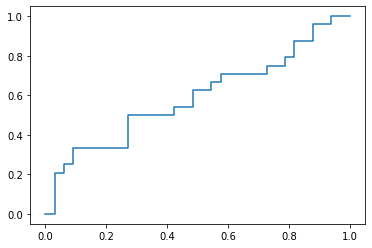

0.5896464646464646


In [47]:
AUC_list = []

# svdd
#     y_train_pred = np.load(f'process_data_utils_battery_brand4_4/{prefix}DeepSVDD_normalize_use_ind_only_fold%d_y_train_pred.npy' % fold_num)

y_train_scores = [np.load(f'gaussian_process/{dataset_name}/y_train_scores_fold0_start{_i}.npy') for _i in range(ind_car_num)]
y_train_scores = np.hstack(y_train_scores)
y_test_pred = [np.load(f'gaussian_process/{dataset_name}/y_test_pred_fold0_start{_i}.npy') for _i in range(ood_car_num)]
y_test_pred = np.hstack(y_test_pred)
y_test_scores = [np.load(f'gaussian_process/{dataset_name}/y_test_scores_fold0_start{_i}.npy') for _i in range(ood_car_num)]
y_test_scores = np.hstack(y_test_scores)
y_test = [np.load(f'gaussian_process/{dataset_name}/y_test_fold0_start{_i}.npy').reshape(-1) for _i in range(ood_car_num)]
y_test = np.hstack(y_test)

print(y_train_scores.shape, y_test_pred.shape, y_test_scores.shape, y_test.shape)

# ind_car_num_list = [411, 410, 434, 449, 423, 414, 431, 485, 446, 466, 453, 480, 455, 488, 402, 439, 427, 409, 442, 448, 428, 452, 429, 484, 482, 457, 459, 499, 413, 461, 403, 470, 481, 493, 417, 496, 407, 495, 418, 426, 436, 491, 500, 474, 476, 487, 430, 451, 498, 401, 463, 494, 406, 420, 497, 433, 435, 440, 416, 464, 445, 479, 425, 460, 490, 478, 467, 447, 412, 489, 444, 422, 477, 437, 415, 486, 441, 421, 471, 432, 483, 450, 468, 443, 456, 469, 472, 438, 408, 458, 454]
# ood_car_num_list = [424, 419, 473, 462, 492, 465, 404, 405, 475]


# 这里只用来load data，实际的car number在下面，这里没有错
car_number_train = ind_car_num_list
car_number_test = ood_car_num_list

# build 3 column csv file
all_car_dict = np.load('../five_fold_utils/all_car_dict.npz.npy', allow_pickle=True).item()

car_train = []
for each_num in car_number_train:
    for each_pkl in all_car_dict[each_num]:
        car_train.append(each_num)
car_test = []
for each_num in car_number_test:
    for each_pkl in all_car_dict[each_num]:
        car_test.append(each_num)
print(len(car_train))
print(len(car_test))
car_train = np.array(car_train)
car_test = np.array(car_test)


print(y_train_scores.shape)
print(y_test_scores.shape)

car_label_train = []
car_label_test = []

for each in car_train:
    if each in ind_car_num_list:
        car_label_train.append(0)
    if each in ood_car_num_list:
        car_label_train.append(1)
for each in car_test:
    if each in ind_car_num_list:
        car_label_test.append(0)
    if each in ood_car_num_list:
        car_label_test.append(1)
car_label_train = np.array(car_label_train)
car_label_test = np.array(car_label_test)

data_train = np.vstack((car_label_train, car_train, y_train_scores)).T
data_test = np.vstack((car_label_test, car_test, y_test_scores)).T

data = np.vstack((data_train, data_test))

print(data_train.shape)
print(data_test.shape)
#     print(data_train[:5, ])
print(data.shape)

validation_car_number = ind_car_num_list[:int(fold_num * len(ind_car_num_list) / 5)] + ind_car_num_list[int((fold_num + 1) * len(ind_car_num_list) / 5):] + ood_car_num_list[int(fold_num * len(ood_car_num_list) / 5):int((fold_num + 1) * len(ood_car_num_list) / 5)]
test_car_number = ind_car_num_list[int(fold_num * len(ind_car_num_list) / 5):int((fold_num + 1) * len(ind_car_num_list) / 5)] + ood_car_num_list[:int(fold_num * len(ood_car_num_list) / 5)] + ood_car_num_list[int((fold_num + 1) * len(ood_car_num_list) / 5):]


validation_data = []
test_data = []

for each_line in data:
    if each_line[1] in validation_car_number:
        validation_data.append(each_line)
    else:
        test_data.append(each_line)

validation_data = np.array(validation_data)
test_data = np.array(test_data)
print(validation_data.shape, test_data.shape)

rec_sorted_index = np.argsort(-validation_data[:, 2].astype(float))
res = [validation_data[i][[1, 0, 2]] for i in rec_sorted_index]
result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
result['car'] = result['car'].astype("int").astype("str")
best_n, max_percent, granularity = find_best_percent(result, granularity_all=1000)
head_n = best_n / granularity
data_length = round(len(result) * head_n)
threshold_n = result['rec_error'].values[data_length - 1].astype(float)
print("threshold_n", threshold_n)
print("训练集自检调参开始,flag is", 'rec_error')
# dtype = object 否则可能会把车号转成int


best_result, best_h, best_re, best_fa, best_f1, best_auroc = find_best_result(threshold_n, result, dataframe_std)
# best_result.to_csv(os.path.join(self.args.result_path, "train_res.csv")),
if dataframe_std.shape[0] == best_result.shape[0]:
    pass
else:
    print('dataframe_std is ', dataframe_std.shape[0], '&&   dataframe is ', best_result.shape[0])
print("最好的1000分之%d:" % best_h)
print("检出率:", best_re)
print("误报率:", best_fa)
print("F1:", best_f1)
rec_sorted_index = np.argsort(-test_data[:, 2].astype(float))
res = [test_data[i][[1, 0, 2]] for i in rec_sorted_index]
result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
result['car'] = result['car'].astype("int").astype("str")
# result.to_csv(os.path.join(self.args.result_path, "test_segment_scores.csv"))
test_result = charge_to_car(threshold_n, result, head_n=best_h)

_score = list(test_result['error'])
_label = []
for each_car in test_result['car']:
    if int(each_car) in ind_car_num_list:
        _label.append(0)
    if int(each_car) in ood_car_num_list:
        _label.append(1)

fpr, tpr, thresholds = metrics.roc_curve(_label, _score, pos_label=1)

np.save(f'gaussian_process/{dataset_name}/gp_robust_score_fold%d.npy' % fold_num, _score)
np.save(f'gaussian_process/{dataset_name}/gp_robust_label_fold%d.npy' % fold_num, _label)

# print(_label, _score)
plt.plot(fpr, tpr)
plt.show()
AUC = auc(fpr, tpr)
print(AUC)
AUC_list.append(AUC)



In [51]:
y_train_scores = []
y_test_pred = []
y_test_scores = []
y_test = []

ind_car_num_list = []
ood_car_num_list = []

dataset_name = 'brand1'
ind_car_num_list = [129, 158, 152, 79, 95
        , 114, 34, 177, 99, 138, 163, 54, 45, 115, 66, 87, 47, 57, 31, 195, 36, 102,
                        72, 173, 94, 51, 92, 61, 153, 125, 103, 3, 50, 10, 7, 146, 166, 48, 75, 86, 15, 175, 64, 2, 110, 13,
                        23, 93, 116, 62, 8, 41, 22, 6, 24, 101, 46, 187, 198, 142, 131, 18, 160, 56, 29, 141, 148, 168, 71,
                        53, 104, 120, 154, 20, 17, 111, 133, 63, 35, 83, 5, 88, 159, 145, 176, 127, 77, 118, 52, 81, 121,
                        59, 38, 80, 109, 179, 28, 123, 44, 180, 149, 135, 164, 74, 40, 14, 65, 69, 42, 193, 12, 60, 73, 126,
                        161, 188, 32, 30, 170, 128, 167, 9, 155, 156, 43, 100, 33, 90, 139, 1, 112, 25, 4, 16, 189, 147,
                        124, 178, 55, 85, 122, 96, 162, 132, 89, 19, 27, 84, 39, 151, 67, 26, 172, 76, 37, 143, 58, 165, 97,
                        134, 82, 113, 137, 144, 70, 11, 117, 106]  # 169
ood_car_num_list = [91, 192, 169, 130, 140
    , 171, 190, 186, 105, 49, 181, 157, 183, 185, 194, 98, 191, 136, 119, 196, 107, 68, 108, 78, 182, 150, 174, 21, 184, 197]
y_train_scores += [np.load(f'gaussian_process/{dataset_name}/y_train_scores_fold0_start{_i}.npy') for _i in range(len(ind_car_num_list))]
y_test_pred += [np.load(f'gaussian_process/{dataset_name}/y_test_pred_fold0_start{_i}.npy') for _i in range(len(ood_car_num_list))]
y_test_scores += [np.load(f'gaussian_process/{dataset_name}/y_test_scores_fold0_start{_i}.npy') for _i in range(len(ood_car_num_list))]
y_test += [np.load(f'gaussian_process/{dataset_name}/y_test_fold0_start{_i}.npy').reshape(-1) for _i in range(len(ood_car_num_list))]

dataframe_std1 = pd.read_csv(os.path.join('../data/battery_brand1/label', "train_label.csv"), dtype=object)
dataframe_std2 = pd.read_csv(os.path.join('../data/battery_brand1/label', "test_label.csv"), dtype=object)


dataset_name = 'brand2'
ind_car_num_list = [214, 231, 233, 234, 218, 201, 211, 248, 222, 203, 223, 246, 229, 249, 227, 207, 232, 250, 208, 245,
                        213, 228, 220, 244, 217, 238, 221, 224, 226, 216, 202, 242, 235]  # 33
ood_car_num_list = [205, 247, 241, 204, 206, 210, 243, 240, 219, 225, 209, 237, 236, 212, 215, 239]
y_train_scores += [np.load(f'gaussian_process/{dataset_name}/y_train_scores_fold0_start{_i}.npy') for _i in range(len(ind_car_num_list))]
y_test_pred += [np.load(f'gaussian_process/{dataset_name}/y_test_pred_fold0_start{_i}.npy') for _i in range(len(ood_car_num_list))]
y_test_scores += [np.load(f'gaussian_process/{dataset_name}/y_test_scores_fold0_start{_i}.npy') for _i in range(len(ood_car_num_list))]
y_test += [np.load(f'gaussian_process/{dataset_name}/y_test_fold0_start{_i}.npy').reshape(-1) for _i in range(len(ood_car_num_list))]

dataframe_std3 = pd.read_csv(os.path.join('../data/battery_brand2/label', "train_label.csv"), dtype=object)
dataframe_std4 = pd.read_csv(os.path.join('../data/battery_brand2/label', "test_label.csv"), dtype=object)

dataset_name = 'brand3'
ind_car_num_list = [411, 410, 434, 449, 423, 414, 431, 485, 446, 466, 453, 480, 455, 488, 402, 439, 427, 409, 442,
                        448, 428, 452, 429, 484, 482, 457, 459, 499, 413, 461, 403, 470, 481, 493, 417, 496, 407, 495,
                        418, 426, 436, 491, 500, 474, 476, 487, 430, 451, 498, 401, 463, 494, 406, 420, 497, 433, 435,
                        440, 416, 464, 445, 479, 425, 460, 490, 478, 467, 447, 412, 489, 444, 422, 477, 437, 415, 486,
                        441, 421, 471, 432, 483, 450, 468, 443, 456, 469, 472, 438, 408, 458, 454]
ood_car_num_list = [424, 419, 473, 462, 492, 465, 404, 405, 475]
y_train_scores += [np.load(f'gaussian_process/{dataset_name}/y_train_scores_fold0_start{_i}.npy') for _i in range(len(ind_car_num_list))]
y_test_pred += [np.load(f'gaussian_process/{dataset_name}/y_test_pred_fold0_start{_i}.npy') for _i in range(len(ood_car_num_list))]
y_test_scores += [np.load(f'gaussian_process/{dataset_name}/y_test_scores_fold0_start{_i}.npy') for _i in range(len(ood_car_num_list))]
y_test += [np.load(f'gaussian_process/{dataset_name}/y_test_fold0_start{_i}.npy').reshape(-1) for _i in range(len(ood_car_num_list))]

dataframe_std5 = pd.read_csv(os.path.join('../data/battery_brand3/label', "all_label.csv"), dtype=object) 
dataframe_std = pd.concat([dataframe_std1, dataframe_std2, dataframe_std3, dataframe_std4, dataframe_std5], axis=0,ignore_index=True)

y_train_scores = np.hstack(y_train_scores)
y_test_pred = np.hstack(y_test_pred)
y_test_scores = np.hstack(y_test_scores)
y_test = np.hstack(y_test)

#     dataframe_std3['car'] = (dataframe_std3['car'].astype("int")+200).astype("str")
#     dataframe_std4['car'] = (dataframe_std4['car'].astype("int")+200).astype("str")
#     dataframe_std5['car'] = (dataframe_std5['car'].astype("int")+300).astype("str")

print(dataframe_std)


     car label
0      1     0
1      2     0
2      3     0
3      4     0
4      5     0
5      6     0
6      7     0
7      8     0
8      9     0
9     10     0
10    11     0
11    12     0
12    13     0
13    14     0
14    15     0
15    16     0
16    17     0
17    18     0
18    19     0
19    20     0
20    21     1
21    22     0
22    23     0
23    24     0
24    25     0
25    26     0
26    27     0
27    28     0
28    29     0
29    30     0
..   ...   ...
318  471     0
319  472     0
320  473     1
321  474     0
322  475     1
323  476     0
324  477     0
325  478     0
326  479     0
327  480     0
328  481     0
329  482     0
330  483     0
331  484     0
332  485     0
333  486     0
334  487     0
335  488     0
336  489     0
337  490     0
338  491     0
339  492     1
340  493     0
341  494     0
342  495     0
343  496     0
344  497     0
345  498     0
346  499     0
347  500     0

[348 rows x 2 columns]


In [52]:
dataset_name = 'all'
ind_car_num_list = [129, 158, 152, 79, 95
        , 114, 34, 177, 99, 138, 163, 54, 45, 115, 66, 87, 47, 57, 31, 195, 36, 102,
                        72, 173, 94, 51, 92, 61, 153, 125, 103, 3, 50, 10, 7, 146, 166, 48, 75, 86, 15, 175, 64, 2, 110, 13,
                        23, 93, 116, 62, 8, 41, 22, 6, 24, 101, 46, 187, 198, 142, 131, 18, 160, 56, 29, 141, 148, 168, 71,
                        53, 104, 120, 154, 20, 17, 111, 133, 63, 35, 83, 5, 88, 159, 145, 176, 127, 77, 118, 52, 81, 121,
                        59, 38, 80, 109, 179, 28, 123, 44, 180, 149, 135, 164, 74, 40, 14, 65, 69, 42, 193, 12, 60, 73, 126,
                        161, 188, 32, 30, 170, 128, 167, 9, 155, 156, 43, 100, 33, 90, 139, 1, 112, 25, 4, 16, 189, 147,
                        124, 178, 55, 85, 122, 96, 162, 132, 89, 19, 27, 84, 39, 151, 67, 26, 172, 76, 37, 143, 58, 165, 97,
                        134, 82, 113, 137, 144, 70, 11, 117, 106] + [214, 231, 233, 234, 218, 201, 211, 248, 222, 203, 223, 246, 229, 249, 227, 207, 232, 250, 208, 245,
                        213, 228, 220, 244, 217, 238, 221, 224, 226, 216, 202, 242, 235] + [411, 410, 434, 449, 423, 414, 431, 485, 446, 466, 453, 480, 455, 488, 402, 439, 427, 409, 442,
                        448, 428, 452, 429, 484, 482, 457, 459, 499, 413, 461, 403, 470, 481, 493, 417, 496, 407, 495,
                        418, 426, 436, 491, 500, 474, 476, 487, 430, 451, 498, 401, 463, 494, 406, 420, 497, 433, 435,
                        440, 416, 464, 445, 479, 425, 460, 490, 478, 467, 447, 412, 489, 444, 422, 477, 437, 415, 486,
                        441, 421, 471, 432, 483, 450, 468, 443, 456, 469, 472, 438, 408, 458, 454]
ood_car_num_list = [91, 192, 169, 130, 140
    , 171, 190, 186, 105, 49, 181, 157, 183, 185, 194, 98, 191, 136, 119, 196, 107, 68, 108, 78, 182, 150, 174, 21, 184, 197] + [205, 247, 241, 204, 206, 210, 243, 240, 219, 225, 209, 237, 236, 212, 215, 239] +  [424, 419, 473, 462, 492, 465, 404, 405, 475]